# Jane Street Data Challenge

- Datasets from Kaggle Competition: https://www.kaggle.com/c/jane-street-market-prediction/data
- Note: this is a sample code, the parameters and results were not final results
- Feel free to use and don't forget upvote & credit :)

**Table of Contents**

[I. Load Library and Data Functions](#section1)

[II. Exploratory Data Analysis](#section2)

1. Import Data & Preliminatory Analysis
2. Feature Plots (Saved to Pdf)
3. Target Exploration
4. Feature Correlation Analysis

[III. Data Preprocessing](#section3)
1. Dealing with Missing Values
2. Dimension Reduction using PCA and Hierarchy Clustering

[IV. Modeling](#section4)


## I. Load Lib and Data Functions <a id='section1'></a>

### Load Library

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import scipy
import os

### Data Functions


In [4]:
def review_numerical_variable(df):
    return df.select_dtypes(exclude='object').describe().transpose().sort_values('mean',ascending=False)

def review_category_variable(df,n):
    results = pd.DataFrame()
    for col in df.select_dtypes(include='object'):
        feature = df[col].replace(np.NaN, 'Missing')
        summary = feature.value_counts(dropna=False)/df.shape[0]
        summary = summary.round(2).sort_values(ascending=False).reset_index()
        other = summary.iloc[n+1:][col].sum()
        summary = summary.iloc[:n+1].transpose().reset_index()
        summary['other'] = other
        summary['index'] = col
        summary['Unique_Values'] = feature.nunique()
        summary.rename(columns = {'index':'Column'},inplace = True)
        results = pd.concat([results, summary])
    results.reset_index(inplace = True)
    results['index'] = results['index'].apply(lambda x:'name' if x == 0 else 'perc')
    return results


def missing_value_check(df):
    summary = df.isnull().sum().reset_index().rename({'index':'var',0:'count'},axis=1).sort_values('count',ascending=False).reset_index(drop=True)
    summary['perc'] = summary['count']/df.shape[0]
    return summary[summary['count']>0]



## II. Exploration Data Analysis <a id='section2'></a>


1. Import Data & Preliminatory Analysis
2. Feature Plots (Saved to Pdf)
3. Target Exploration
4. Feature Correlation Analysis



### Import  Data & Preliminatory Analysis

In [5]:
#df = pd.read_csv('/content/gdrive/MyDrive/Data/train.csv')
df = pd.read_csv(dir + 'train.csv')

In [7]:
df = df.sample(n = 10000)

In [10]:
#Define Target
df['action'] = (df.resp > 0).astype('int')

In [11]:
#feature list
features_list = [c for c in df.columns if 'feature' in c]

In [12]:
#Review numerical features
summary_num = review_numerical_variable(df[features_list])

In [222]:
#Review categorical features
cat_num = review_category_variable(df[features_list],2) 

### Feature Plots

In [14]:
def feature_plot(f):
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    axs[0].hist(df[f],bins = 50)
    try:
        axs[1].hist(np.log(df[f]),bins = 50)
    except:
        pass
    axs[2].hist(df[df.resp>0][f], bins = 50)
    sample = df.sample(5000)
    axs[3].scatter(sample[f],sample['resp'],marker = '.')
    axs[3].set_xlabel(f)
    axs[3].set_ylabel('resp')

    axs[0].set_title('feature distribution')
    axs[1].set_title('log transform')
    axs[2].set_title('distribution resp > 0')

    axs[3].set_title('feature vs. response')
    return fig

In [ ]:
import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt


with PdfPages('feature_plot.pdf') as pdf:
    for feature in [c for c in df.columns if 'feature' in c]:
        plt.rc('text', usetex=False)
        fig = feature_plot(feature)
        pdf.savefig() 
        plt.close()

### Target Exploration

In [21]:
df['action'].value_counts()/len(df)

1    0.5075
0    0.4925
Name: action, dtype: float64

### Feature Correlation

<AxesSubplot:>

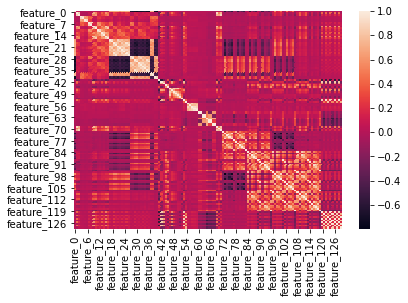

In [27]:
sns.heatmap(df[features_list].corr())

## III. Data Preprocessing  <a id='section3'></a>

1. Dealing with Missing Values
2. Dimension Reduction using PCA and Hierarchy Clustering

### Dealing with Missing Values

In [16]:
num_missing = pd.isna(df).sum()
perc_missing = num_missing/df.shape[0]

In [17]:
na_col_list = df.columns[pd.isna(df).any()].tolist()

In [39]:
perc_missing[perc_missing > 0].sort_values(ascending = False)

feature_18    0.1598
feature_28    0.1598
feature_27    0.1598
feature_17    0.1598
feature_7     0.1584
               ...  
feature_56    0.0002
feature_4     0.0001
feature_45    0.0001
feature_44    0.0001
feature_3     0.0001
Length: 84, dtype: float64

#### 1. Input missing values using Sklearn

In [40]:
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [43]:
imp = IterativeImputer(n_nearest_features = 10, max_iter=5, random_state=0)
df_fillna = imp.fit_transform(df.values)

In [44]:
df_fillna = pd.DataFrame(df_fillna, index=df.index, columns=df.columns)

In [45]:
sum(df_fillna.isna().sum()>0)

0

In [ ]:
df_fillna.to_csv('/content/gdrive/MyDrive/Data/df_fillna.csv')

### Dimension Reduction

In [ ]:
# Standardize the features first
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#features_rescaled = StandardScaler().fit_transform(df_fillna[features_list].values)
features_rescaled = MinMaxScaler().fit_transform(df_fillna[features_list].values)

#### 1. PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components = 0.99)
pca.fit(features_rescaled)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

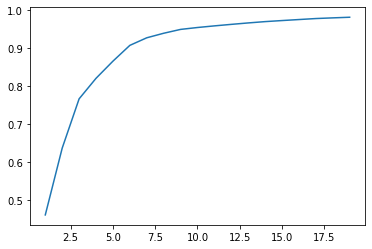

In [ ]:
y = pca.explained_variance_ratio_
y = np.cumsum(y)
x = np.array(range(1,len(pca.explained_variance_ratio_)+1))
plt.plot(x, y)
plt.show()

In [ ]:
pca_features = pca.transform(features_rescaled)

In [ ]:
len(pca_features[0])

27

In [ ]:
pca_features = pd.DataFrame(pca_features, index=df_fillna.index)

#### 2. Hierachy Clustering

In [49]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [94]:
cut = 0.15
dist = scipy.spatial.distance.pdist(df_fillna[features_list].values.T, 'correlation')
dist = 1 - np.abs(1 - dist)
cluster = linkage(dist, 'complete')
len(cluster)

129

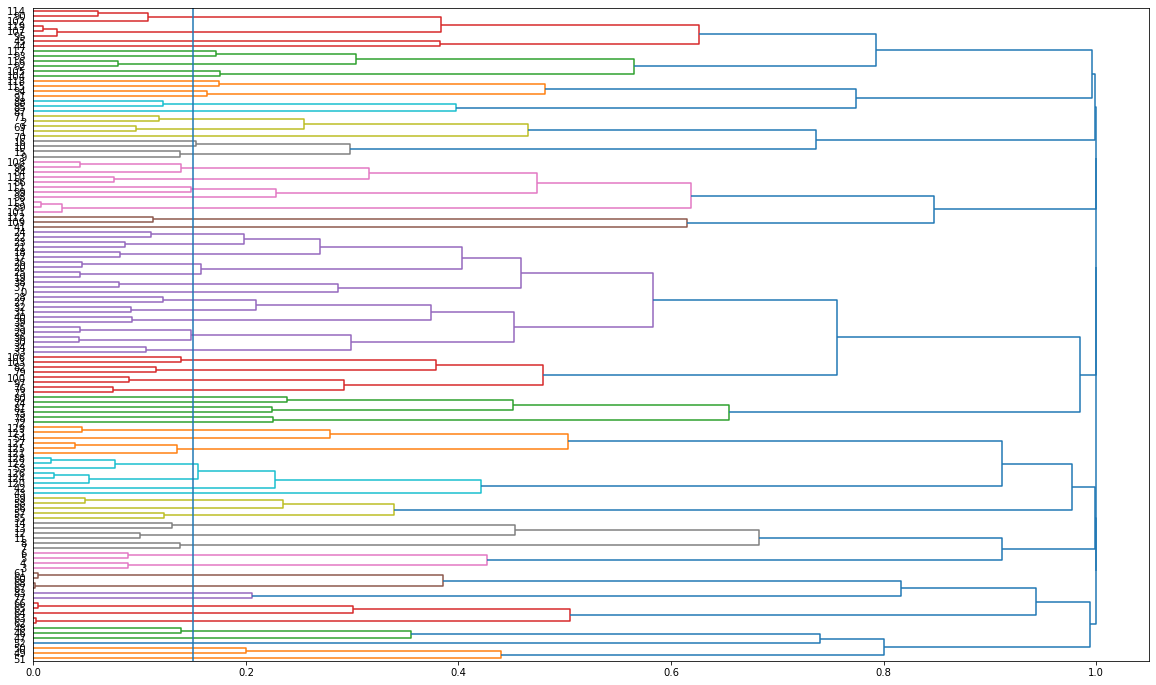

In [95]:
plt.rcParams['figure.figsize'] = [20,12]
dendrogram(cluster, orientation = 'right', leaf_font_size = 10)
plt.axvline(x = cut)
plt.show()

In [139]:
cluster_s = fcluster(cluster, cut, criterion = 'distance')
print('# of cluster: {}'.format(np.max(cluster_s)))
df_cluster = pd.DataFrame({'cluster':cluster_s, 'colnames':df_fillna[features_list].columns})

# of cluster: 78


In [121]:
from minepy import MINE

In [126]:
m = MINE()
res = []
for feature in features_list:
    m.compute_score(df_fillna[feature],df_fillna['action'])
    res.append([feature,m.mic()])

In [146]:
mi_df = pd.DataFrame(res, columns = ['colnames', 'mi'])
df_cluster = df_cluster.merge(mi_df, how = 'inner')

In [156]:
features_selected = df_cluster.iloc[df_cluster.groupby('cluster')['mi'].idxmax()]['colnames'].values

In [158]:
len(features_selected)

78

## IV. Modeling
<a id='section4'></a>

### Data Prep

In [210]:
# Standardize the features first
#df_model = pd.read_csv('/content/gdrive/MyDrive/Data/df_fillna.csv')
df_model = df_fillna.copy()
features_list = features_selected#[c for c in df_fillna.columns if 'feature' in c]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
features_rescaled = StandardScaler().fit_transform(df_model[features_list].values)

### Model Evaluation and Selection Functions

In [198]:
#Evaluation Funtions

from sklearn.model_selection import cross_validate, KFold, cross_val_score, LeaveOneGroupOut, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

def cv_score(model, X, y, n):
    res = cross_val_score(model, X, y, scoring = 'roc_auc', cv = n)
    return res

def model_selection_score(model, X, y, folds):
    scores = []
    for train_index, test_index in folds.split(X):       
        if type(X) == np.ndarray:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        else:
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores.append(roc_auc_score(y_test, pred))
    return scores

### XGBoost

In [194]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import roc_auc_score

#### BayesOptimization

In [215]:
ss = ShuffleSplit(n_splits=2, test_size= 100, random_state=2021)
for train_index, test_index in ss.split(features_rescaled):
    df_model.values[train_index]

In [216]:
ss = ShuffleSplit(n_splits=2, test_size= 100, random_state=2021)
def shuffle_xgb(learning_rate, n_estimators, max_depth, gamma, subsample, colsample_bytree):
    ss_results = model_selection_score(xgb.XGBClassifier(max_depth=int(max_depth), learning_rate=learning_rate,
                                               n_estimators=int(n_estimators),verbosity=1,
                                subsample=subsample, colsample_bytree = colsample_bytree,gamma = gamma
                                #tree_method='gpu_hist' 
                                                        ), 
              features_rescaled, df_model['action'].values, ss)
    return sum(ss_results)/len(ss_results)

In [ ]:
xgb_bo = BayesianOptimization(shuffle_xgb, {
                                             'gamma': (0.1, 0.2),
                                            'n_estimators':(3,10),
                                             'learning_rate':(0.08,0.09),

                                            'max_depth': (5, 10),
                                            'subsample':(0.8, 0.8),
                                            'colsample_bytree':(0.8, 0.8)                 
                                            })

xgb_bo.maximize(n_iter=30, init_points=15, acq='ei')

In [ ]:
best_params = xgb_bo.max['params']

#### Random Grid Search

In [218]:
#use hyper optimization as an initial 
init_params = {
              'learning_rate':0.09,
               'n_estimators': 10,

              'max_depth': 10,
              'subsample': 0.9,
              'colsample_bytree':0.6,

              'gamma': 0.7,
              'eval_metric': 'auc',

              'tree_method' : 'gpu_hist'
            }

In [219]:
init_ss_results = shuffle_xgb(learning_rate=init_params['learning_rate'], n_estimators=init_params['n_estimators'], 
                              max_depth=init_params['max_depth'], gamma=init_params['gamma'], 
                              subsample=init_params['subsample'], colsample_bytree=init_params['colsample_bytree'])

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:40:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
#1. Optimizing Max depth using a realtive large learning rate

In [ ]:
res = []
for _max_depth in [26,30]:
    res.append([_max_depth, shuffle_xgb(learning_rate=init_params['learning_rate'], n_estimators=init_params['n_estimators'], 
          max_depth=_max_depth, gamma=init_params['gamma'], subsample=init_params['subsample'], colsample_bytree=init_params['colsample_bytree'])])

In [ ]:
#2. Optimizing regularization parameters

In [ ]:
res = []
for _gamma in [0.1, 0.15, 0.2, 0.3 , 0.5]:
    res.append([max_depth, shuffle_xgb(learning_rate=init_params['learning_rate'], n_estimators=init_params['n_estimators'], 
          max_depth=best_max_depth, gamma=_gamma, subsample=init_params['subsample'], colsample_bytree=init_params['colsample_bytree'])])
res

In [ ]:
#3. Optimizing sampling parameters

In [ ]:
param_dist = {
 'subsample':range(0.5,0.9),
 'colsample_bytree':range(0.5,0.9)
}

rs = RandomSearchCV(estimator = xgb.XGBClassifier(
  max_depth = init_params['max_depth'],
 learning_rate =init_params['learning_rate'],
 n_estimators=init_params['n_estimators'],
 #subsample=init_params['subsample'],
  #colsample_bytree=init_params['colsample_bytree'],
  gamma = init_params['gamma'],
  tree_method = 'gpu_hist'
), 
param_grid = param_dist, scoring='auc',n_jobs=1,iid=False, cv=5)

rs.fit(features_rescaled,df_fillna['action'])

In [ ]:
#4. Optimizing learning rate

In [ ]:
param_dist = {
 'learning_rate':range(0.01,0.1)
}

gs = GridSearchCV(estimator = xgb.XGBClassifier(
  max_depth = init_params['max_depth'],
 #learning_rate =init_params['learning_rate'],
 n_estimators=init_params['n_estimators'],
 subsample=init_params['subsample'],
  colsample_bytree=init_params['colsample_bytree'],
  gamma = init_params['gamma'],
  tree_method = 'gpu_hist'
), 
param_grid = param_dist, scoring='auc',n_jobs=1,iid=False, cv=5)

gs.fit(features_rescaled,df_fillna['action'])